In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from simple_keras import KerasFunctional

2023-05-21 19:16:33.395981: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-21 19:16:33.447468: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-21 19:16:33.448298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 19:16:34.385909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/hojve/repos/github/deep-learning/deep-learning-fundamentals/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as 

In [2]:
# Split
split = ['train[:15%]', 'test[:10%]', 'test[10%:20%]']

# Load cats_vs_dogs dataset
(ds_train, ds_eval, ds_test), ds_info = tfds.load(
    name='fashion_mnist',
    split=split,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
len(ds_train)

9000

In [4]:
# Print info
print(len(ds_train))
print(len(ds_eval))
print(len(ds_test))
print(ds_train.element_spec)

# Calculate number of classes in label
num_classes = ds_info.features['label'].num_classes
print(num_classes)

9000
1000
1000
(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
10


In [5]:
img_input_shape = (28, 28, 1)
img_n_classes = 10

2023-05-21 19:16:36.311200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-21 19:16:36.311837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-21 19:16:36.361604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{n

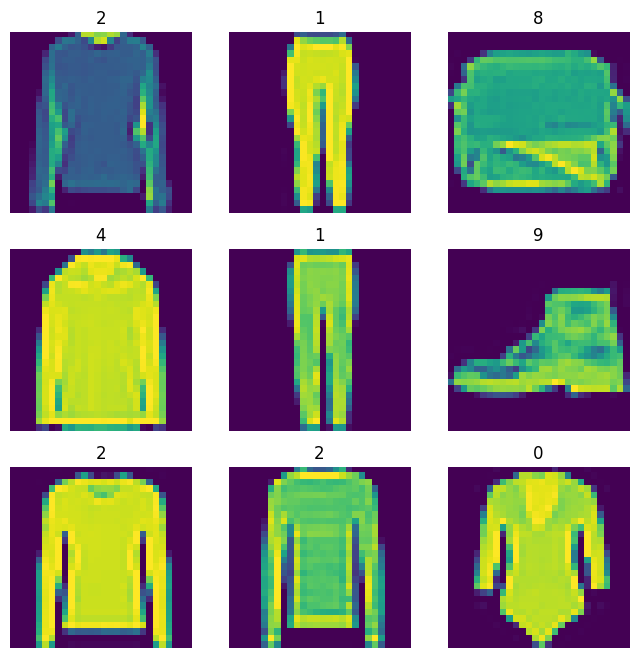

In [6]:
images_iter = iter(x_train for x_train, _ in ds_train.take(9).cache().repeat())
labels_iter = iter(y_train for _, y_train in ds_train.take(9).cache().repeat())
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")

In [7]:
def normalize(image, label):
    """Normalize image pixels."""
    return tf.cast(image, tf.float32) / 255.0, label

In [8]:
# Normalize train and test data
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_eval = ds_eval.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
# Print element spec after preprocessing
print(ds_train.element_spec)
print(ds_eval.element_spec)
print(ds_test.element_spec)

(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [10]:
# Cache train data
ds_train = ds_train.cache()

# Shuffle data for true randomness and to reduce memory usage
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)

# Set batch size
ds_train = ds_train.batch(64)

# Prefetch
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [11]:
# Set batch size
ds_eval = ds_eval.batch(64)
ds_test = ds_test.batch(64)

# Cache test data
ds_eval = ds_eval.cache()
ds_test = ds_test.cache()

# Prefetch
ds_eval = ds_eval.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [12]:
# Instantiate classifier
clf = KerasFunctional(input_shape=img_input_shape, n_classes=img_n_classes)

In [13]:
# Train model
clf.call(ds_train=ds_train, ds_eval=ds_eval, epochs=100)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         136       
                                                                 
 re_lu (ReLU)                (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 16)          528       
                                                                 
 re_lu_1 (ReLU)              (None, 4, 4, 16)          0         
                                                             

2023-05-21 19:16:37.548838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-05-21 19:16:37.549828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
/home/hojve/repos/github/deep-learning/deep-learning-fundamentals/.venv/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?


139/141 [============================>.] - ETA: 0s - loss: 2.1772 - accuracy: 0.1992

2023-05-21 19:16:39.567740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-21 19:16:39.568282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


141/141 [==============================] - 2s 9ms/step - loss: 2.1744 - accuracy: 0.2010 - val_loss: 1.9250 - val_accuracy: 0.3650
Epoch 2/100
141/141 [==============================] - 1s 8ms/step - loss: 1.5265 - accuracy: 0.5240 - val_loss: 1.2017 - val_accuracy: 0.6410
Epoch 3/100
141/141 [==============================] - 1s 7ms/step - loss: 1.0559 - accuracy: 0.6633 - val_loss: 0.9681 - val_accuracy: 0.6810
Epoch 4/100
141/141 [==============================] - 1s 7ms/step - loss: 0.8959 - accuracy: 0.6969 - val_loss: 0.8788 - val_accuracy: 0.7080
Epoch 5/100
141/141 [==============================] - 1s 8ms/step - loss: 0.8214 - accuracy: 0.7176 - val_loss: 0.8358 - val_accuracy: 0.7060
Epoch 6/100
141/141 [==============================] - 1s 8ms/step - loss: 0.7793 - accuracy: 0.7320 - val_loss: 0.8057 - val_accuracy: 0.7120
Epoch 7/100
141/141 [==============================] - 1s 8ms/step - loss: 0.7498 - accuracy: 0.7378 - val_loss: 0.7744 - val_accuracy: 0.7250
Epoch 8/100

In [14]:
df_loss, df_acc = clf.pd_history()

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

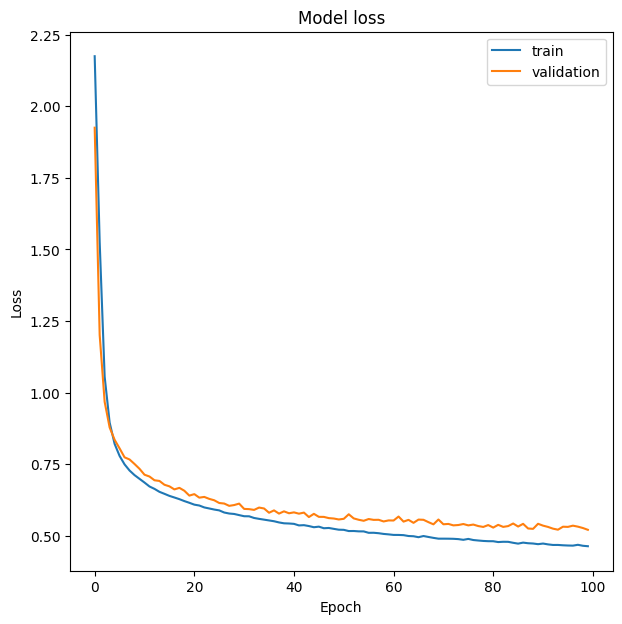

In [17]:
df_loss.plot(
    title='Model loss',
    figsize=(7, 7)
).set(xlabel='Epoch', ylabel='Loss')

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

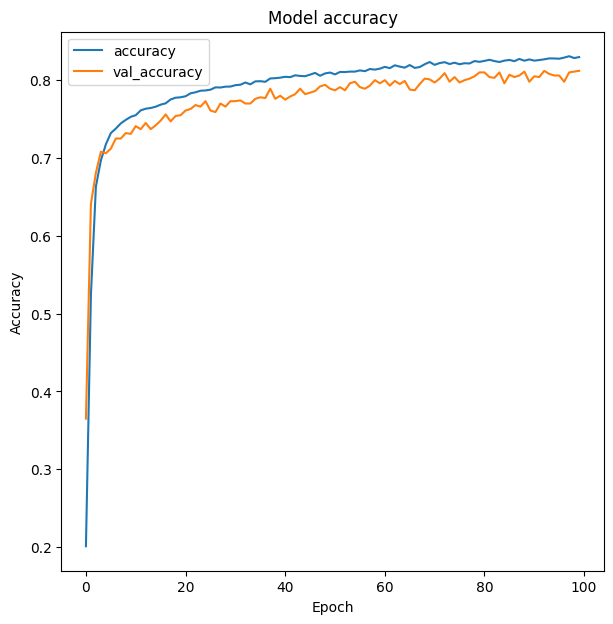

In [18]:
df_acc.plot(
    title='Model accuracy',
    figsize=(7, 7)
).set(xlabel='Epoch', ylabel='Accuracy')

Text(0.5, 0, 'Epochs')

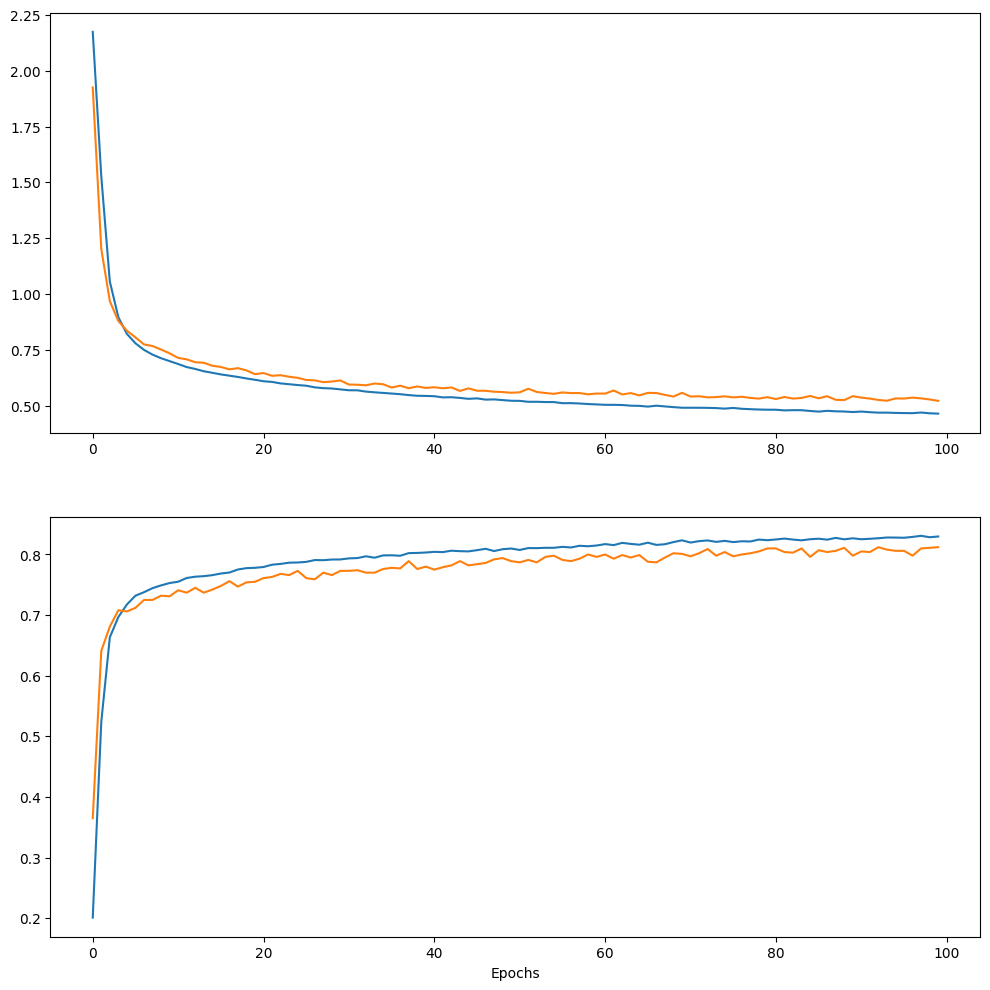

In [22]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(df_loss)
plt.subplot(2, 1, 2)
plt.plot(df_acc)
plt.xlabel('Epoch')
